# Определение опытных игроков Dota 2 (руководство по решению)

В игре Dota 2 участвуют две стороны: команды сил Света (The Radiant) и сил Тьмы (The Dire). Каждая команда состоит из 5 игроков — персонажей со своими уникальными способностями. Перед началом матча каждый игрок выбирает себе одного героя из 116 возможных. Цель игры — разрушить трон, находящийся на базе противника.

Повышая игровые навыки, игроки повышают свой рейтинг и получают медали опыта. Эксперты по игре Dota 2 утверждают, что легко могут отличить матч новичка от игры опытного игрока.

**Задача — построить алгоритм, который сможет определять опытность игрока по статистике из одного матча.**

## Таблицы с данными

Рассмотрим упрощённый набор данных в виде таблиц `skill_train.csv` и `skill_test.csv`, с которыми удобно оперировать и подавать в алгоритмы машинного обучения.

In [1]:
%pylab inline
import pandas

Populating the interactive namespace from numpy and matplotlib


In [2]:
df_train = pandas.read_csv('data/dota2_skill_train.csv', index_col='id')
df_test = pandas.read_csv('data/dota2_skill_test.csv', index_col='id')

In [3]:
df_train.head()

,skilled,player_team,winner_team,duration,pre_game_duration,first_blood_time,first_blood_claimed,hero_id,hero_pick_order,leaver_status,...,avg_deaths_x16,avg_assists_x16,avg_gpm_x16,avg_xpm_x16,best_kills_x16,best_assists_x16,best_gpm_x16,best_xpm_x16,win_streak,best_win_streak
id,,,,,,,,,,,,,,,,,,,,,
7,1,dire,dire,2140,90,129,0,90,9,0,...,8,15,352,430,10,30,551,745,2,5
8,0,radiant,radiant,2138,90,174,0,5,5,0,...,9,19,294,425,13,37,445,717,2,12
12,0,radiant,radiant,3547,90,360,0,81,7,0,...,7,9,493,543,23,18,691,762,3,3
13,1,dire,radiant,1878,90,28,0,74,9,0,...,7,12,515,583,25,34,869,935,0,6
14,1,dire,radiant,2232,90,129,0,14,6,0,...,10,16,337,452,34,43,672,797,0,9


### Значение полей таблиц с данными

Целевая переменная:
- `skilled`: 1 — опытный игрок, 0 — новичок; эту колонку необходимо предсказывать для тестовой выборки

Информация про матч:
- `player_team`: команда, за которую играл игрок (`radiant` или `dire`)
- `winner_team`: победившая команда
- `hero_id`: идентификатор героя, за которого играл целевой игрок (расшифровку см. в таблице `heroes.csv`)
- `duration`: длительность игры в секундах
- `first_blood_time`: время события "первая кровь"
- `first_blood_claimed`: сделал ли целевой игрок "первую кровь"
- `party_players`: сколько игроков было в "пати" вместе с целевым

Показатели целевого игрока в матче:
- `kills`, `deaths`, `assists`, `denies`, `last_hits` — основные игровые показатели (число убийств вражеских героев, число смертей, и др.)
- `stuns`: нанесенные "оглушения" (в секундах)
- `level`: уровень, которого достиг герой к концу игры
- `net_worth`: общая стоимость всего инвентаря героя
- `gold`: число золота на момент игры
- `gold_spent`: сумма потраченного золота за всю игру
- `gold_per_min`: скорость зарабатывания золота
- `xp_per_min`: скорость получения опыта
- `hero_damage`: суммарный урон по вражеским героям
- `tower_damage`: сумарный урон по вражеским башням
- `hero_healing`: суммарное восстановленное здоровье союзных героев 
- `team_fight_participation`: участие в драках
- `observer_wards_placed`, `sentry_wards_placed`: количество установленных на карту "вардов" (предметы, дающие обзор)
- `rune_pickups`: количество собранных рун
- `radiant_tower_status`, `dire_tower_status`: состояние башен команд на конец игры (см. [расшифровку](https://wiki.teamfortress.com/wiki/WebAPI/GetMatchDetails#Tower_Status))
- `radiant_barracks_status`, `dire_barracks_status`: состояние бараков команд на конец игры (см. [расшифровку](https://wiki.teamfortress.com/wiki/WebAPI/GetMatchDetails#Barracks_Status))

Показатели по последним матчам игрока:
- `avg_kills_x16`, `avg_deaths_x16`, `avg_assists_x16`, `avg_gpm_x16`, `avg_xpm_x16`: средние значения показателей за последние 16 игр
- `best_kills_x16`, `best_assists_x16`, `best_gpm_x16`, `best_xpm_x16`: максимальные значения показателей за последние 16 игр
- `win_streak`, `best_win_streak`: число подряд выигранных матчей до текущего, максимальное число подряд выигранных матчей

## Расширенный набор данных

В дополнение к таблицам имеются расширенные наборы данных: `skill_train.jsonlines`, `skill_test.jsonlines` — это текстовые файлы, в каждой строчке записан объект в формате [JSON](https://ru.wikipedia.org/wiki/JSON). В объектах есть все поля из таблиц, но кроме этого есть дополнительные поля, список приведен ниже.

Пример чтения файла в формате "JSON Lines":

In [4]:
with open('data/dota2_skill_train.jsonlines') as fin:
    for line in fin:
        record = json.loads(line)
        # обработка record
        
        break

### Значения полей

- `damage_targets`: количество нанесенного игроком урона по всем видам юнитов
- `radiant_heroes`, `dire_heroes`: список идентификаторов героев у всех игроков в команде (расшифровку см. в таблице `heroes.csv`)
- `final_items`: предметы инвентаря, собранные игроком к концу игры (0 означает отсутствие предмета в соответствующем слоте, расшифровку предметов см. в таблице `items.csv`)
- `level_up_times`: время, в которое герой игрока повышал уровень
- `ability_upgrades`: последовательность улучшений умений, которые делал игрок (возможность улучшить умение возникает при повышении уровня героя, расшифровка умений см. в таблице `abilities.csv`)
- `item_purchase_log`
- `series`: временные ряды изменения игровых показателей во времени
  - `time`: отсчеты времени
  - `radiant_gold`, `dire_gold`: суммарное число золота, заработанного командами
  - `player_gold`: число золота, заработанное игроком

Рассмотрим один пример из расширенного набора. Как и в таблицах, каждая запись имеет свой идентификатор:

In [5]:
record['id']

7

#### Изменение золота в игре

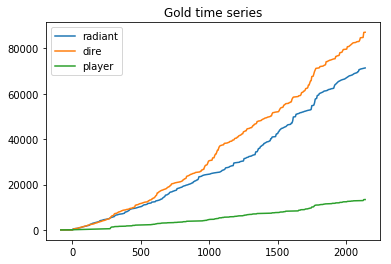

In [6]:
series = record['series']
plot(series['time'], series['radiant_gold'])
plot(series['time'], series['dire_gold'])
plot(series['time'], series['player_gold'])
title('Gold time series')
_ = legend(['radiant', 'dire', 'player'])

В качестве вспомогательной информации есть описание героев `heroes.csv`, предметов `items.csv` и умений `abilities.csv`.

#### Составы команд

In [7]:
df_heroes = pandas.read_csv('data/dota2_heroes.csv', index_col='hero_id')

Герои команды **Radiant**:

In [8]:
df_heroes.loc[record['radiant_heroes'], :]

,name,localized_name,roles,agi_gain,attack_range,attack_rate,attack_type,base_agi,base_armor,base_attack_max,...,base_mr,base_str,cm_enabled,int_gain,legs,move_speed,primary_attr,projectile_speed,str_gain,turn_rate
hero_id,,,,,,,,,,,,,,,,,,,,,
120,npc_dota_hero_pangolier,Pangolier,"['Carry', 'Nuker', 'Disabler', 'Durable', 'Esc...",3.2,150,1.7,Melee,18,1.0,39,...,25,17,True,1.9,2,305,agi,900,2.5,1.0
7,npc_dota_hero_earthshaker,Earthshaker,"['Support', 'Initiator', 'Disabler', 'Nuker']",1.4,150,1.7,Melee,12,0.0,37,...,25,22,True,1.8,2,310,str,0,3.7,0.9
101,npc_dota_hero_skywrath_mage,Skywrath Mage,"['Support', 'Nuker', 'Disabler']",0.8,600,1.7,Ranged,13,-2.0,24,...,25,21,True,4.1,2,325,int,1000,2.0,0.5
111,npc_dota_hero_oracle,Oracle,"['Support', 'Nuker', 'Disabler', 'Escape']",1.7,620,1.4,Ranged,15,0.0,24,...,25,20,True,4.0,2,300,int,900,2.4,0.7
81,npc_dota_hero_chaos_knight,Chaos Knight,"['Carry', 'Disabler', 'Durable', 'Pusher', 'In...",2.1,150,1.7,Melee,14,1.0,59,...,25,22,True,1.2,2,320,str,900,3.7,0.5


Герои команды **Dire**:

In [9]:
df_heroes.loc[record['dire_heroes'], :]

,name,localized_name,roles,agi_gain,attack_range,attack_rate,attack_type,base_agi,base_armor,base_attack_max,...,base_mr,base_str,cm_enabled,int_gain,legs,move_speed,primary_attr,projectile_speed,str_gain,turn_rate
hero_id,,,,,,,,,,,,,,,,,,,,,
45,npc_dota_hero_pugna,Pugna,"['Nuker', 'Pusher']",1.0,630,1.7,Ranged,16,0.0,27,...,25,19,True,5.2,2,330,int,900,2.0,0.5
62,npc_dota_hero_bounty_hunter,Bounty Hunter,"['Escape', 'Nuker']",2.6,150,1.7,Melee,21,3.0,38,...,25,20,True,2.0,2,315,agi,900,2.5,0.6
90,npc_dota_hero_keeper_of_the_light,Keeper of the Light,"['Support', 'Nuker', 'Disabler', 'Jungler']",1.6,600,1.7,Ranged,15,-1.0,27,...,25,16,True,3.2,2,330,int,900,2.3,0.5
129,npc_dota_hero_mars,Mars,"['Carry', 'Initiator', 'Disabler', 'Durable']",1.9,250,1.8,Melee,20,0.0,43,...,25,23,False,1.4,2,310,str,900,3.6,0.8
53,npc_dota_hero_furion,Nature's Prophet,"['Carry', 'Jungler', 'Pusher', 'Escape', 'Nuker']",3.3,600,1.7,Ranged,18,2.0,43,...,25,21,True,3.3,2,290,int,1125,2.6,0.6


## Решение 1: "Заглушка"

В обучающей выборке больше неопытных игроков, чем опытных:

In [10]:
df_train['skilled'].value_counts()

0    60085
1    39786
Name: skilled, dtype: int64

В случае, если мы не имеем никакой информации об игроке, имеет смысл предсказывать что он _неопытный_. Основываясь на этом принципе, можем построить первое решение: для всех тестовых примеров определять игрока как _неопытного_.

Оценим точность такого предсказания на обучающей выборке (доля угаданных значений целевой переменной): 

In [11]:
dummy_accuracy = (df_train['skilled'] == 0).mean()
print('Train accuracy:', dummy_accuracy)

Train accuracy: 0.6016260976659892


Запишем предсказания в CSV-файл `sample_submission.csv`:

In [12]:
df_submission_dummy = pandas.DataFrame({'skilled': 0}, index=df_test.index)
df_submission_dummy.to_csv('sample_submission.csv')
df_submission_dummy.head()

,skilled
id,
0,0
1,0
4,0
5,0
9,0


Эти предсказания можно отправлять в проверяющую систему.

## Решение 2: Находим закономерность

Если посмотреть на распределения различных переменных по опытным и неопытным игрокам, то можно обнаружить, что игроки с достаточно высоким `avg_gpm_x16` как правило опытные:

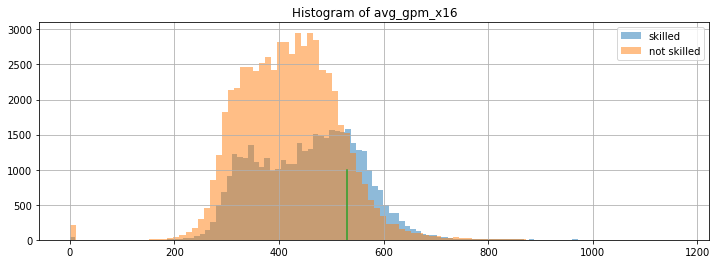

In [13]:
selected_column = 'avg_gpm_x16'
threshold = 530

figure(figsize=(12, 4))
df_train.loc[df_train.skilled == 1, selected_column].hist(bins=100, alpha=0.5)
df_train.loc[df_train.skilled == 0, selected_column].hist(bins=100, alpha=0.5)
legend(['skilled', 'not skilled'])
plot([threshold, threshold], [0, 1000])
_ = title('Histogram of {}'.format(selected_column))

Используя это наблюдения, можно построить более точное решение:
- если `avg_gpm_x16 > 530` => вероятно игрок опытный, предсказываем `skilled=1`
- иначе => скорее всего неопытный, предсказываем `skilled=0`

Используя этот алгоритм, построим предсказания для обучающей и тестовой выборок:

In [14]:
skilled_train_pred = (df_train[selected_column] > threshold).astype(int)
skilled_test_pred = (df_test[selected_column] > threshold).astype(int)

Оценим качество получившегося решения (долю примеров с правильно угаданным `skilled`) на обучающей выборке:

In [15]:
print('Train accuracy:', (skilled_train_pred == df_train['skilled']).mean())

Train accuracy: 0.6377927526509197


Доля правильных предсказаний существенно выше чем в решении-"заглушке". Сохраним предсказания в CSV-файл, который можно отправлять в систему:

In [16]:
df_submission_rule = pandas.DataFrame({'skilled': skilled_test_pred})
df_submission_rule.to_csv('submission_rule.csv')
df_submission_rule.tail(10)

,skilled
id,
193369,1
193372,0
193375,0
193389,0
193391,0
193392,0
193393,0
193402,0
193410,1


## Решение 3: Дерево решений

Dummy-решение с константным ответом и решение на основе одного признака получились лучше, чем случайное решение, но можно двигаться дальше. Одним из простых алгоритмов машинного обучения дерево решений. Основная идея в разделении объектов выборки на основе простых правил так, чтобы каждой группе сопоставить некоторый ответ.

#### Матрица объект-признак

Исключим из обучающей выборки целевую переменную и два строковых признака.

In [17]:
X = df_train.drop(columns=['skilled', 'player_team', 'winner_team'])
X_test = df_test.drop(columns=['player_team', 'winner_team'])
y = df_train['skilled']

#### Построение решающего дерева

Обучением решающее дерево глубины 4. На визуализации можно увидеть, какие правила для разделения выборки были получены.

In [18]:
from sklearn.tree import DecisionTreeClassifier

tree_classifier = DecisionTreeClassifier(max_depth=4).fit(X, y)

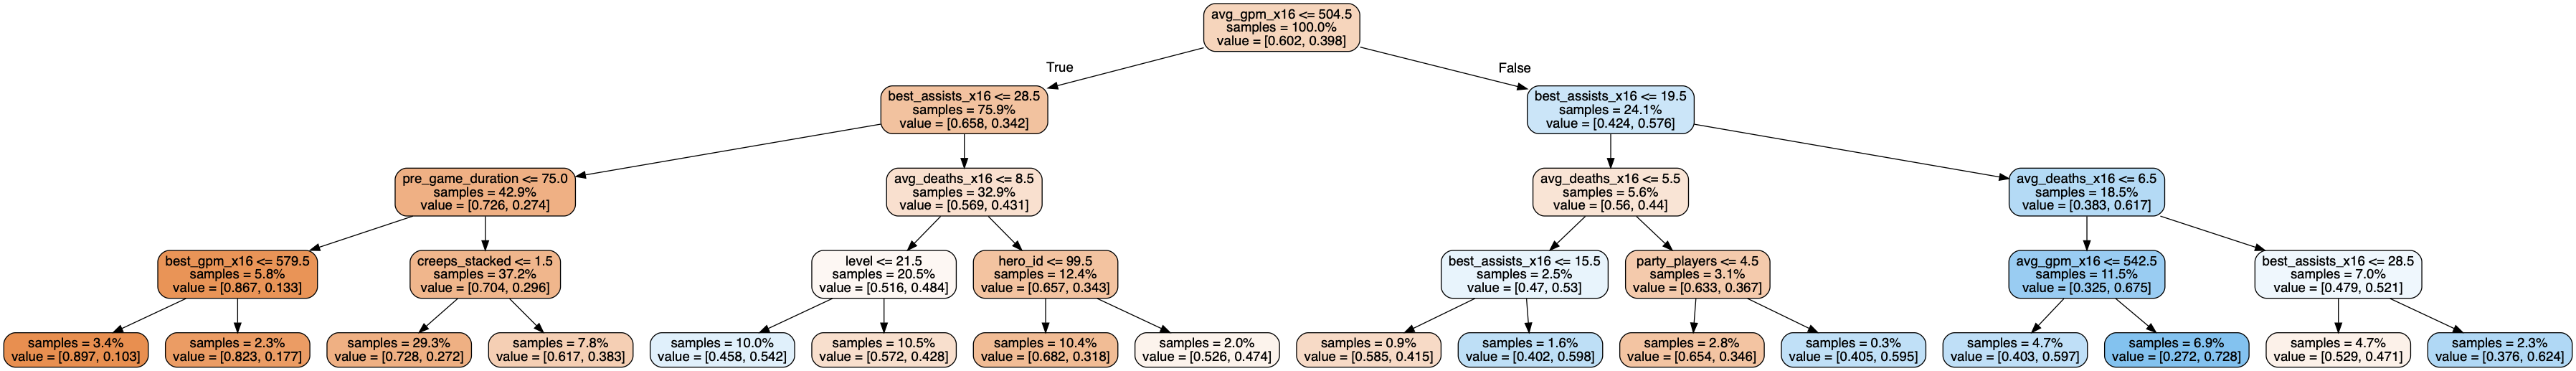

In [19]:
from sklearn.tree import export_graphviz
export_graphviz(
    tree_classifier,
    out_file='skill_tree.dot',
    feature_names=X.columns,
    filled=True,
    proportion=True,
    rounded=True,
    impurity=False,
)
!dot -Tpng skill_tree.dot -o skill_tree.png

from IPython.display import Image
Image('skill_tree.png')

#### Предсказания на тестовой выборке

Сделаем предсказание деревом решений на тестовой выборке и сохраним предсказания в файл.

In [20]:
y_pred = tree_classifier.predict(X_test)
df_submission_tree = pandas.DataFrame({'skilled': y_pred}, index=df_test.index)
df_submission_tree.to_csv('submission_tree.csv')
df_submission_tree.tail()

,skilled
id,
193392,0
193393,0
193402,0
193410,0
193411,0


#### Оценка качества на обучающей выборке

In [21]:
from sklearn.metrics import accuracy_score

print('Train accuracy:', accuracy_score(y, tree_classifier.predict(X)))

Train accuracy: 0.659701014308458


#### Оценка качества методом кросс-валидации

Оценка качества модели на обучающей выборке некорректна, так как мы оцениваем качество алгоритма, который видел правильные ответы (и мог их запомнить). Для избежения этого используют кросс-валидацию, то есть оценивают качество алгоритма на частях обучающей выборки, которую не видел алгоритм при обучении.

In [22]:
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(
    DecisionTreeClassifier(max_depth=4),
    X, y,
    cv=5,
    n_jobs=-1,
)

print('Validation accuracy:', accuracy_score(df_train['skilled'], y_pred))

Validation accuracy: 0.6575282113926966


## Идеи по дальнейшему улучшению точности решения

### Подбор параметров модели

Для получения более высокого качества часто необходимо подобрать значения параметров алгоритма. Например, у решающего дерева есть параметр глубина дерева `max_depth`. Увеличим значение с 4 до 8. 

In [23]:
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(
    DecisionTreeClassifier(max_depth=8),
    X, y,
    cv=5,
    n_jobs=-1,
)

print('Validation accuracy:', accuracy_score(df_train['skilled'], y_pred))

Validation accuracy: 0.6730181934695757


Качество алгоритма выросло!

### Использование различных алгоритмов машинного обучения

Решающие деревья — один из методов машинного обучения, есть много других алгоритмов, которые при правильном использовании могут дать лучший результат. Воспользуемся, например, случайным лесом — множеством решающих деревьев, ответы которых усредняются.

In [24]:
from sklearn.ensemble import RandomForestClassifier

y_pred = cross_val_predict(
    RandomForestClassifier(n_estimators=100),
    X, y,
    cv=5,
    n_jobs=-1,
)

print('Validation accuracy:', accuracy_score(df_train['skilled'], y_pred))

Validation accuracy: 0.7155230247018654


### Использование категориальных признаков

В нашей выборке есть числовые признаки, которые по смыслу означают категории. Например, герой, за которого играл человек. Посмотрим на различия в `avg_gpm_x16` у двух типов героев. 

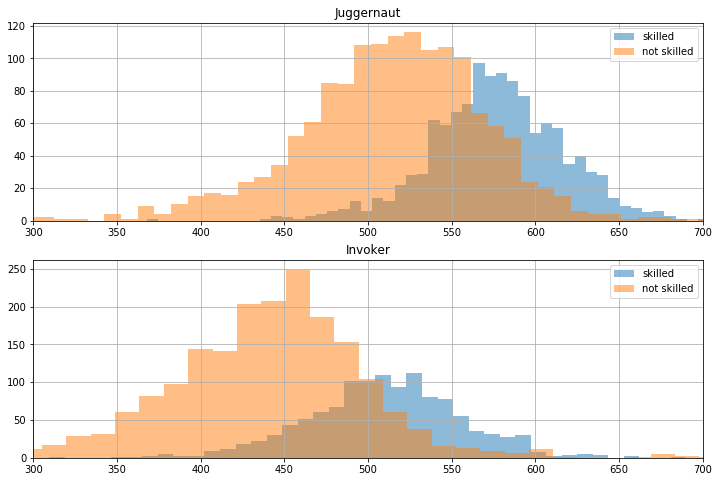

In [25]:
selected_heroes = [(8, 'Juggernaut'), (74, 'Invoker')]

figure(figsize=(12, 8))
for i, (selected_hero, hero_name) in enumerate(selected_heroes):
    subplot(len(selected_heroes), 1, i+1)
    df_train.loc[(df_train.skilled == 1) & (df_train.hero_id == selected_hero), selected_column].hist(bins=50, alpha=0.5)
    df_train.loc[(df_train.skilled == 0) & (df_train.hero_id == selected_hero), selected_column].hist(bins=50, alpha=0.5)
    xlim([300, 700])
    legend(['skilled', 'not skilled'])
    title(hero_name)

Большинство алгоритмов машинного обучения не понимает, что признак по смыслу категориальный, а считает его числом. Поэтому попробуем добавить признаки `играл за героя X` для всех возможных героев.

In [26]:
for hero_id in set(df_train.hero_id):
    df_train['is_hero_{}'.format(hero_id)] = df_train.hero_id == hero_id
    df_test['is_hero_{}'.format(hero_id)] = df_test.hero_id == hero_id

X = df_train.drop(columns=['skilled', 'player_team', 'winner_team'])
X_test = df_test.drop(columns=['player_team', 'winner_team'])
y = df_train['skilled']

y_pred = cross_val_predict(
    RandomForestClassifier(n_estimators=100),
    X, y,
    cv=5,
    n_jobs=-1,
)

print('Validation accuracy:', accuracy_score(df_train['skilled'], y_pred))

Validation accuracy: 0.7161338126182776


### Использование расширенного набора данных, создание новых признаков

Как уже говорилось, есть дополнительная информация о героях, умениях и предметах. Можно сгенерировать новые признаки на их основе. 

Посчитаем, каких типов умения применялись игроков и в каком количестве. Для этого нужно воспользовать большой версией данных (это займёт некоторое время).

In [27]:
df_abilities = pandas.read_csv('data/dota2_abilities.csv', index_col='ability_id')
df_abilities.behavior = df_abilities.behavior.apply(
    lambda x: x.split("'")).apply(lambda x: x[1] if len(x) > 1 else 'empty')
df_abilities.head()

,dname,behavior,desc
ability_id,,,
5003,antimage_mana_break,Passive,Burns an opponent's mana on each attack. Mana...
5004,antimage_blink,Point Target,Short distance teleportation that allows Anti-...
5005,antimage_spell_shield,Passive,Increases Anti-Mage's resistance to magic dama...
7314,antimage_counterspell,No Target,Passively grants you magic resistance. Can be ...
5006,antimage_mana_void,Unit Target,For each point of mana missing by the target u...


In [28]:
import tqdm

for ability_behavior in set(df_abilities.behavior.fillna('empty')):
    df_train['upgrade_behavior {}'.format(ability_behavior)] = 0
    df_test['upgrade_behavior {}'.format(ability_behavior)] = 0
    
with open('data/dota2_skill_train.jsonlines') as fin:
    for line in tqdm.tqdm_notebook(fin):
        record = json.loads(line)
        for ability_upgrade in record['ability_upgrades']:
            df_train.loc[record['id'], 'upgrade_behavior {}'.format(
                df_abilities.loc[ability_upgrade, 'behavior'])] += 1
            
with open('data/dota2_skill_test.jsonlines') as fin:
    for line in tqdm.tqdm_notebook(fin):
        record = json.loads(line)
        for ability_upgrade in record['ability_upgrades']:
            df_test.loc[record['id'], 'upgrade_behavior {}'.format(
                df_abilities.loc[ability_upgrade, 'behavior'])] += 1

In [29]:
X = df_train.drop(columns=['skilled', 'player_team', 'winner_team'])
X_test = df_test.drop(columns=['player_team', 'winner_team'])
y = df_train['skilled']

y_pred = cross_val_predict(
    RandomForestClassifier(n_estimators=100),
    X, y,
    cv=5,
    n_jobs=-1,
)

print('Validation accuracy:', accuracy_score(df_train['skilled'], y_pred))

Validation accuracy: 0.7206296121997376


### Ансамблирование моделей

Один алгоритм хорошо, а несколько могут решить задачу лучше (там, где один не уверен, другой может дать правильный ответ). Возьмём к случайному лесу градиентный бустинг (ещё один алгоритм на основе решающих деревьев), предскажем с помощью них степень уверенности в `1` (вероятность того, что игрок `skilled`). Усредним их и переведём в предсказание классов.

In [30]:
from sklearn.ensemble import GradientBoostingClassifier

In [31]:
X = df_train.drop(columns=['skilled', 'player_team', 'winner_team'])
X_test = df_test.drop(columns=['player_team', 'winner_team'])
y = df_train['skilled']

y_pred_rf = cross_val_predict(
    RandomForestClassifier(n_estimators=100),
    X, y,
    cv=5,
    n_jobs=-1,
    method='predict_proba'
)[:, 1]

y_pred_gb = cross_val_predict(
    GradientBoostingClassifier(),
    X, y,
    cv=5,
    n_jobs=-1,
    method='predict_proba'
)[:, 1]

y_pred = 0.5 * y_pred_rf + 0.5 * y_pred_gb

print('Validation accuracy RF:', accuracy_score(df_train['skilled'], y_pred_rf > 0.5))
print('Validation accuracy GB:', accuracy_score(df_train['skilled'], y_pred_gb > 0.5))
print('Validation accuracy RF+GB:', accuracy_score(df_train['skilled'], y_pred > 0.5))

Validation accuracy RF: 0.7197084238667881
Validation accuracy GB: 0.7159135284517028
Validation accuracy RF+GB: 0.722902544282124


Сохраним таблицу с предсказаниями.

In [32]:
model_rf = RandomForestClassifier(n_estimators=100)
model_rf.fit(X, y)
y_pred_rf = model_rf.predict_proba(X_test)[:, 1]

model_gb = GradientBoostingClassifier()
model_gb.fit(X, y)
y_pred_gb = model_gb.predict_proba(X_test)[:, 1]

y_pred = ((0.5 * y_pred_rf + 0.5 * y_pred_gb) > 0.5).astype(int)
df_submission = pandas.DataFrame({'skilled': y_pred}, index=df_test.index)
df_submission.to_csv('submission_ensemble.csv')
df_submission.tail()

,skilled
id,
193392,0
193393,0
193402,0
193410,0
193411,0


### Использовать опыт решения других соревнований

[YouTube: Тренировки по машинному обучению](https://www.youtube.com/channel/UCeq6ZIlvC9SVsfhfKnSvM9w)

[Материалы Академии Искусственного Интеллекта 2018](http://contest.ai-academy.ru/description)

[YouTube: Александр Мамаев — Предсказание победы команды в матче Dota2](https://www.youtube.com/watch?v=YSQqHlQwQDY&t=50s)